In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from pprint import pprint

import src
from src.reload import deep_reload

In [42]:
'''
Creating a random graph

graph contains n destinations and m chargers

the random graph is completely connected
'''
deep_reload(src)

seed = 125396749
n = 15
m = 85
speeds = [105]
chargers = list(range(10))
scale = (1e6, 1e6)

graph = src.rng.random_completely_connected_graph(
    n, m, speeds = speeds, scale = scale, seed = seed, chargers = chargers,
)

graph = src.routing.edge_types(graph)

destinations = [k for k, v in graph._node.items() if v['type'] is 'destination']

In [43]:
graph.number_of_nodes(), graph.number_of_edges()

(100, 5050)

In [533]:
'''
Running with Dijkstra with default objective
'''
deep_reload(src)

objective = src.routing.Scout(field = 'distance', edge_limit = 200e3)

t0 = time.time()

costs, values, paths = src.routing.shortest_paths(
    graph, ['destination_4'],
    objective = objective,
    return_paths = True,
    destinations = destinations,
)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 0.0059 seconds


In [366]:
pprint({k: v / 1e3 for k, v in costs.items() if 'station' not in k})

{'destination_0': 724.5411923628253,
 'destination_1': 861.5837162518645,
 'destination_10': 623.8285187041813,
 'destination_11': 688.0599402789518,
 'destination_12': 417.02841978739167,
 'destination_13': 737.855957833795,
 'destination_14': 198.23530526885756,
 'destination_2': 964.9018455275132,
 'destination_3': 729.4265081073211,
 'destination_4': 0.0,
 'destination_5': 594.8099191399866,
 'destination_6': 566.5595088392472,
 'destination_7': 523.3217366654012,
 'destination_8': 617.6289998492891,
 'destination_9': 194.0200378711101}


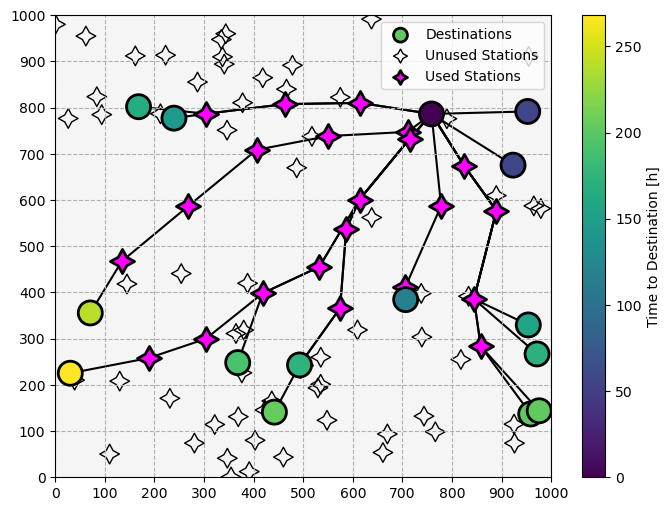

In [363]:
deep_reload(src)

fig, ax = plt.subplots(figsize = (8, 6))

kw = src.figures.default_route_tree_kwargs

color = (254 / 255, 214 / 255, 1 / 255)

src.figures.plot_route_tree(
    ax, graph,
    values = {k: v / 3600 for k, v in values.items()},
    paths = {k: v for k, v in paths.items() if graph._node[k]['type'] is 'destination'},
    destinations = destinations,
    # show_used_stations = False,
    **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

    ax.grid(ls = '--')

In [544]:
'''
Running with Double-Dijkstra with default objective
'''
deep_reload(src)

stations = [k for k, v in graph._node.items() if v['type'] is 'station']

origins = destinations
# origins = [destinations[4], destinations[3], destinations[8]]
# origins = [destinations[4], destinations[8]]
# origins = destinations[:3]

objective = src.routing.Scout(field = 'distance', edge_limit = 200e3)

t0 = time.time()

costs, values, paths = src.dijkstra.multi_directional_dijkstra(
    graph, origins,
    objective = objective,
    return_paths = True,
)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 0.0383 seconds


In [545]:
pprint({k: v / 1e3 for k, v in costs['destination_4'].items() if 'station' not in k})

{'destination_0': 724.5411923628253,
 'destination_1': 861.5837162518645,
 'destination_10': 623.8285187041813,
 'destination_11': 688.0599402789518,
 'destination_12': 417.02841978739167,
 'destination_13': 737.8559578337948,
 'destination_14': 199.64659699917428,
 'destination_2': 964.9018455275132,
 'destination_3': 729.4265081073211,
 'destination_4': 0.0,
 'destination_5': 594.8099191399866,
 'destination_6': 566.5595088392472,
 'destination_7': 523.3217366654012,
 'destination_8': 617.6289998492891,
 'destination_9': 196.3923170333457}


In [546]:
pprint({k: v / 1e3 for k, v in values['destination_8'].items() if 'station' not in k})

{'destination_0': 130.54953824454435,
 'destination_1': 949.1474265795583,
 'destination_10': 505.0664559026185,
 'destination_11': 628.3415016223873,
 'destination_12': 296.7540670868034,
 'destination_13': 600.6751324605526,
 'destination_14': 474.75981898392934,
 'destination_2': 969.5983391723564,
 'destination_3': 123.08013576992705,
 'destination_4': 617.6289998492889,
 'destination_5': 1000.6628224623457,
 'destination_6': 65.24527571781985,
 'destination_7': 922.738943653976,
 'destination_8': 0.0,
 'destination_9': 596.1617024065747}


In [547]:
paths['destination_4']['destination_8'], paths['destination_8']['destination_4']

(['destination_4', 'station_49', 'station_73', 'station_46', 'destination_8'],
 ['destination_8', 'station_46', 'station_73', 'station_49', 'destination_4'])

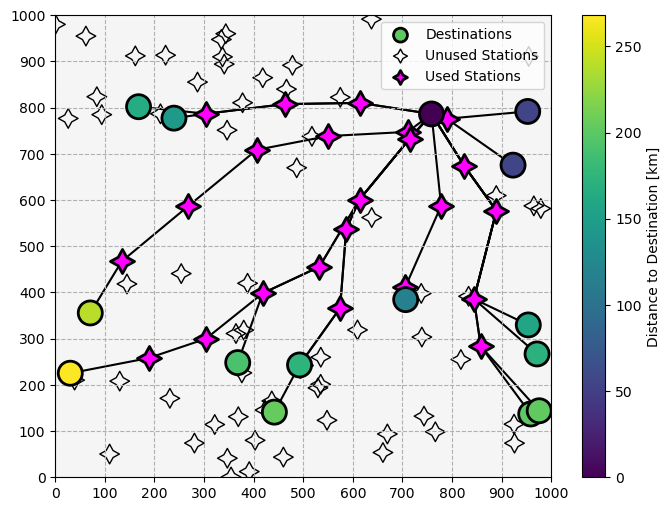

In [548]:
deep_reload(src)

fig, ax = plt.subplots(figsize = (8, 6))

destination = 'destination_4'

destinations = [k for k, v in graph._node.items() if v['type'] is 'destination']

kw = src.figures.default_route_tree_kwargs
kw['destinations_kw']['colorbar']['label'] = 'Distance to Destination [km]'

color = (254 / 255, 214 / 255, 1 / 255)

src.figures.plot_route_tree(
    ax, graph,
    values = {k: v / 3600 for k, v in values[destination].items()},
    paths = {k: v for k, v in paths[destination].items() if k in origins},
    destinations = origins,
    # show_used_stations = False,
    **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

    ax.grid(ls = '--')

In [71]:
'''
Running with Double-Dijkstra with default objective
'''
deep_reload(src)

stations = [k for k, v in graph._node.items() if v['type'] is 'station']

objective = src.routing.Scout(field = 'distance', edge_limit = 200e3)

t0 = time.time()

costs, values, paths = src.routing.shortest_paths(
    graph, destinations,
    objective = objective,
    return_paths = True,
    method = 'bellman',
    destinations = stations,
)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 0.0140 seconds


In [84]:
from heapq import heappop, heappush
heaps = {k: [] for k in range(5)}

for k, heap in heaps.items():
    heappush(heap, 1)

for k, heap in heaps.items():
    heappop(heap)
    
any([heap for heap in heaps.values()]), [heap for heap in heaps.values()], heaps

(False, [[], [], [], [], []], {0: [], 1: [], 2: [], 3: [], 4: []})

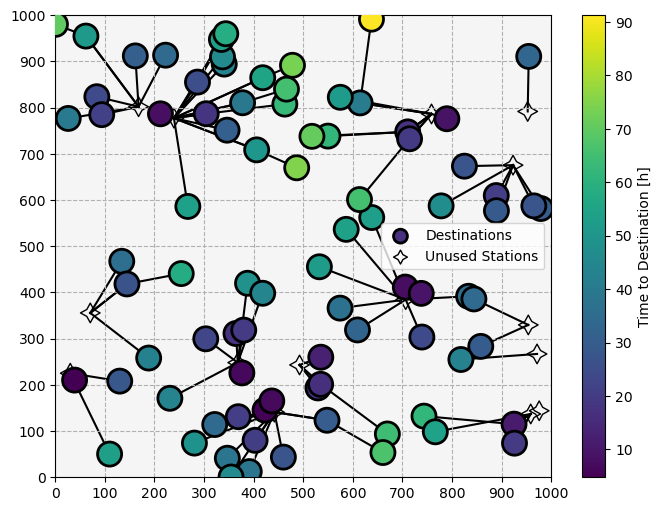

In [72]:
deep_reload(src)

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if v['type'] is 'destination']

kw = src.figures.default_route_tree_kwargs

color = (254 / 255, 214 / 255, 1 / 255)

src.figures.plot_route_tree(
    ax, graph,
    values = {k: v / 3600 for k, v in values.items()},
    paths = {k: v for k, v in paths.items() if graph._node[k]['type'] is 'station'},
    destinations = stations,
    show_used_stations = False,
    **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

    ax.grid(ls = '--')

In [36]:
'''
Running with Bellman with default objective
'''
deep_reload(src)

objective = src.routing.Scout(field = 'distance', edge_limit = 200e3)

t0 = time.time()

costs, values, paths = src.routing.shortest_paths(
    graph, ['destination_0'],
    objective = objective,
    return_paths = True,
    method = 'bellman'
)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 0.0096 seconds


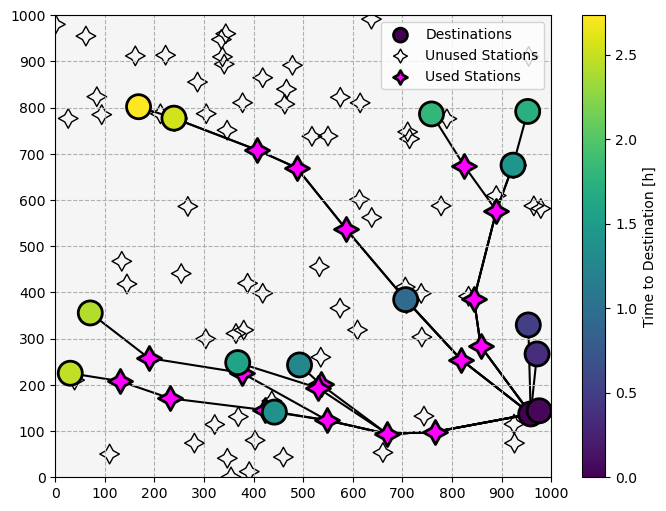

In [37]:
deep_reload(src)

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if v['type'] is 'destination']

kw = src.figures.default_route_tree_kwargs

color = (254 / 255, 214 / 255, 1 / 255)

src.figures.plot_route_tree(
    ax, graph,
    values = {k: v / 3600 for k, v in r[1].items()},
    paths = {k: v for k, v in paths.items() if graph._node[k]['type'] is 'destination'},
    destinations = destinations,
    # show_used_stations = False,
    **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

    ax.grid(ls = '--')

In [14]:
'''
Running with Dijkstra with deterministic vehicle objective
'''
deep_reload(src)

objective = src.routing.Vehicle(capacity = 80 * 3.6e6)

t0 = time.time()

r = src.dijkstra.dijkstra(
    graph, ['destination_0'], objective = objective, return_paths = True
)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 0.0787 seconds


In [15]:
print('Total Time:\n')
pprint({k: v['time'] / 3600 for k, v in r[1].items() if 'station' not in k})
print('\nDriving Time:\n')
pprint({k: v['driving_time'] / 3600 for k, v in r[1].items() if 'station' not in k})
print('\nPaths:\n')
pprint({k: v for k, v in r[2].items() if 'station' not in k})

Total Time:

{'destination_0': 0.0,
 'destination_1': 3.329488711570786,
 'destination_10': 1.264614989476647,
 'destination_11': 2.102770479381132,
 'destination_12': 0.9346209930307693,
 'destination_13': 1.3672406333204534,
 'destination_14': 1.9442915941570351,
 'destination_2': 3.3715431972851726,
 'destination_3': 0.048799704386836514,
 'destination_4': 2.248851851178897,
 'destination_5': 3.92068950325288,
 'destination_6': 0.5100423598869759,
 'destination_7': 3.741686048806584,
 'destination_8': 0.34536914879509084,
 'destination_9': 2.2606477189829977}

Driving Time:

{'destination_0': 0.0,
 'destination_1': 2.4281328241292264,
 'destination_10': 1.264614989476647,
 'destination_11': 1.6448868864959576,
 'destination_12': 0.9346209930307693,
 'destination_13': 1.3672406333204534,
 'destination_14': 1.5218147690378636,
 'destination_2': 2.470187309843613,
 'destination_3': 0.048799704386836514,
 'destination_4': 1.8263750260597256,
 'destination_5': 2.7380171401915927,
 'desti

In [17]:
'''
Running with Bellman with default objective
'''
deep_reload(src)

objective = src.bellman.Objective(field = 'time')

t0 = time.time()

r = src.bellman.bellman(graph, ['destination_0'], objective = objective, return_paths = True)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 0.0044 seconds


In [18]:
print('Total Time:\n')
pprint({k: v / 3600 for k, v in r[1].items() if 'station' not in k})

Total Time:

{'destination_0': 0.0,
 'destination_1': 2.419313306788944,
 'destination_10': 1.264614989476647,
 'destination_11': 1.590188553900052,
 'destination_12': 0.9346209930307693,
 'destination_13': 1.3672406333204534,
 'destination_14': 1.4279561651338475,
 'destination_2': 2.4669537455373023,
 'destination_3': 0.048799704386836514,
 'destination_4': 1.7975298887502689,
 'destination_5': 2.7332218708125624,
 'destination_6': 0.5100423598869759,
 'destination_7': 2.5475886480011085,
 'destination_8': 0.34536914879509084,
 'destination_9': 1.732368058126357}


In [178]:
'''
Running with Bellman with BEV vehicle objective
'''
deep_reload(src)

objective = src.routing.Vehicle(capacity = 80 * 3.6e6)

t0 = time.time()

r = src.bellman.bellman(
    graph, ['destination_0'], objective = objective, return_paths = True
)

print(f'Executed in {time.time() - t0:.4f} seconds')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [20]:
print('Total Time:\n')
pprint({k: v['time'] / 3600 for k, v in r[1].items() if 'station' not in k})
print('\nDriving Time:\n')
pprint({k: v['driving_time'] / 3600 for k, v in r[1].items() if 'station' not in k})
print('\nPaths:\n')
pprint({k: v for k, v in r[2].items() if 'station' not in k})

Total Time:

{'destination_0': 0.0,
 'destination_1': 3.329488711570786,
 'destination_10': 1.264614989476647,
 'destination_11': 2.102770479381132,
 'destination_12': 0.9346209930307693,
 'destination_13': 1.3672406333204534,
 'destination_14': 1.9442915941570351,
 'destination_2': 3.3715431972851726,
 'destination_3': 0.048799704386836514,
 'destination_4': 2.248851851178897,
 'destination_5': 3.92068950325288,
 'destination_6': 0.5100423598869759,
 'destination_7': 3.741686048806584,
 'destination_8': 0.34536914879509084,
 'destination_9': 2.2606477189829977}

Driving Time:

{'destination_0': 0.0,
 'destination_1': 2.4281328241292264,
 'destination_10': 1.264614989476647,
 'destination_11': 1.6448868864959576,
 'destination_12': 0.9346209930307693,
 'destination_13': 1.3672406333204534,
 'destination_14': 1.5218147690378636,
 'destination_2': 2.470187309843613,
 'destination_3': 0.048799704386836514,
 'destination_4': 1.8263750260597256,
 'destination_5': 2.7380171401915927,
 'desti

In [21]:
'''
Running with Bellman with ICEV vehicle objective
'''
deep_reload(src)

objective = src.routing.Vehicle(
    capacity = 528 * 3.6e6,
    efficiency = 550 * 5,
    charge_rate = 14.15e6,
    charge_time_penalty = 300,
)

t0 = time.time()

r = src.bellman.bellman(
    graph, ['destination_0'], objective = objective, return_paths = True
)

print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 0.0153 seconds


In [22]:
print('Total Time:\n')
pprint({k: v['time'] / 3600 for k, v in r[1].items() if 'station' not in k})
print('\nDriving Time:\n')
pprint({k: v['driving_time'] / 3600 for k, v in r[1].items() if 'station' not in k})
print('\nPaths:\n')
pprint({k: v for k, v in r[2].items() if 'station' not in k})

Total Time:

{'destination_0': 0.0,
 'destination_1': 2.528332822970335,
 'destination_10': 1.264614989476647,
 'destination_11': 1.590188553900052,
 'destination_12': 0.9346209930307693,
 'destination_13': 1.3672406333204534,
 'destination_14': 1.4279561651338475,
 'destination_2': 2.5750250868361086,
 'destination_3': 0.048799704386836514,
 'destination_4': 1.7975298887502689,
 'destination_5': 2.8492065342257633,
 'destination_6': 0.5100423598869759,
 'destination_7': 2.6489220811182093,
 'destination_8': 0.34536914879509084,
 'destination_9': 1.732368058126357}

Driving Time:

{'destination_0': 0.0,
 'destination_1': 2.4212072542306164,
 'destination_10': 1.264614989476647,
 'destination_11': 1.590188553900052,
 'destination_12': 0.9346209930307693,
 'destination_13': 1.3672406333204534,
 'destination_14': 1.4279561651338475,
 'destination_2': 2.468332861799405,
 'destination_3': 0.048799704386836514,
 'destination_4': 1.7975298887502689,
 'destination_5': 2.7457196183534522,
 'des

In [158]:
'''
Adding station objects
'''
deep_reload(src)

vehicle = src.routing.StochasticVehicle(
    capacity = 80 * 3.6e6,
    max_charge_start_soc = 1,
    risk_attitude = (.5, 1),
)

for source, node in graph._node.items():

    if node['type'] == 'station':

        node['station'] = src.routing.StochasticStation(
            vehicle, chargers = node['n_dcfc']
        )

In [159]:
'''
Running with Bellman with BEV stochastic vehicle objective
'''
deep_reload(src)

t0 = time.time()

r = src.bellman.bellman(
    graph, ['destination_0'], objective = vehicle, return_paths = True
)


print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 2.2192 seconds


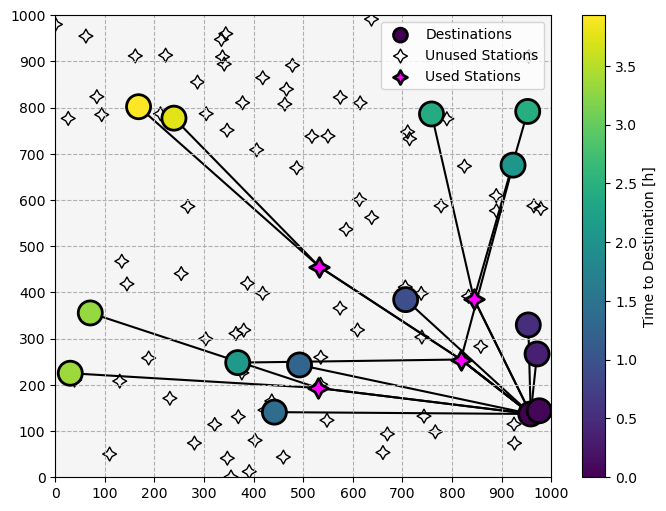

In [177]:
deep_reload(src)

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if v['type'] is 'destination']

kw = src.figures.default_route_tree_kwargs

color = (254 / 255, 214 / 255, 1 / 255)

# kw['destinations_kw']['cmap'] = src.figures.colormap([color, color])
# kw['destinations_kw']['colorbar'] = {}

src.figures.plot_route_tree(
    ax, graph,
    values = {k: v['time'].mean() / 3600 for k, v in r[1].items()},
    # values = {k: .5 for k, v in r[1].items()},
    paths = {k: v for k, v in r[2].items() if graph._node[k]['type'] is 'destination'},
    destinations = destinations,
    **kw,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

    ax.grid(ls = '--')

# plt.colorbar(cax = ax)

In [34]:
'''
Adding station objects
'''
deep_reload(src)

vehicle = src.routing.Vehicle(
    capacity = 80 * 3.6e6,
    max_charge_start_soc = 1,
)

risk_attitude = (0, 1)

for source, node in graph._node.items():

    if node['type'] == 'station':

        node['station'] = src.routing.StochasticStation(
            vehicle, chargers = node['n_dcfc']
        )

        node['expected_delay'] = src.routing.super_quantile(
            node['station'].delay_time, risk_attitude,
        )

In [35]:
'''
Running with Bellman with BEV stochastic vehicle objective
'''
deep_reload(src)

t0 = time.time()

r = src.bellman.bellman(
    graph, ['destination_0'], objective = vehicle, return_paths = True
)


print(f'Executed in {time.time() - t0:.4f} seconds')

Executed in 0.0252 seconds


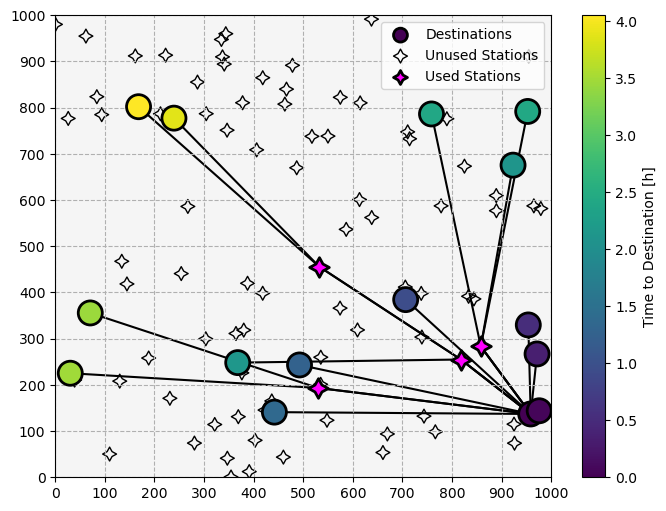

In [156]:
deep_reload(src)

fig, ax = plt.subplots(figsize = (8, 6))

destinations = [k for k, v in graph._node.items() if v['type'] is 'destination']

src.figures.plot_route_tree(
    ax, graph,
    {k: v['time'] / 3600 for k, v in r[1].items()},
    {k: v for k, v in r[2].items() if graph._node[k]['type'] is 'destination'},
    destinations = destinations,
    **src.figures.default_route_tree_kwargs,
)

_ = ax.set(**{
    'xticks': np.linspace(-5e5, 5e5, 11),
    'xticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'xlim': (-5e5, 5e5),
    'yticks': np.linspace(-5e5, 5e5, 11),
    'yticklabels': np.linspace(0, 1e3, 11, dtype = int),
    'ylim': (-5e5, 5e5),
    'facecolor': 'whitesmoke',
})

legend = ax.legend()

for h in legend.legendHandles:
    h._sizes = [100]

    ax.grid(ls = '--')

# plt.colorbar(cax = ax)